### Joint Analysis: Home Prices, Macroeconomic Conditions, and Climate Shocks

Goal: Build a "global" model that forecasts price shifts based on macroeconomic indicators and climate-risk related features

In [78]:
import pandas as pd 
import numpy as np 
import glob
import duckdb
import geopandas as gpd 
import requests
import os 

FRED_api_endpoint = 'https://api.stlouisfed.org/fred/series/observations'
FRED_api_key = '8fd9759bac0caf671d3462eed0b34d68'
HMDA_api_endpoint = 'https://ffiec.cfpb.gov/v2/data-browser-api/view/csv'

econ_dataset_codes = {
    'fed_funding_rate':'DFF', 
    '30yr_mortgage_avg':'MORTGAGE30US', 
    '15yr_mortgage_avg':'MORTGAGE15US',  
    'consumer_price_idx':'CPIAUCSL', 
    'real_disposable_income':'DSPIC96', 
    'real_disp_income_per_capita':'A229RX0'
}

build_tbls = '''
drop table if exists nfip_claims
;

create table nfip_claims as 
select  
    id,
    asOfDate, 
    dateOfLoss,
    policyCount as insuredUnits, 
    baseFloodElevation, 
    ratedFloodZone, 
    occupancyType, 
    originalConstructionDate, 
    originalNBDate, 
    coalesce(amountPaidOnBuildingClaim,0) +                  
    coalesce(amountPaidOnContentsClaim,0) +                  
    coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
    coalesce(totalBuildingInsuranceCoverage,0) + 
    coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
    coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
    buildingDeductibleCode, 
    contentsDeductibleCode,
    causeOfDamage, 
    buildingPropertyValue, 
    floodproofedIndicator, 
    floodEvent, 
    state, 
    reportedZipCode, 
    censusTract, 
    latitude, 
    longitude
from read_csv('{claims_data_path}', strict_mode=False)
;

drop table if exists nfip_claims_zip 
; 

create table nfip_claims_zip as 
select 
    reportedZipCode as zip, 
    state,
    floodEvent,
    dateOfLoss,
    count(id) as claimCounts,
    sum(insuredUnits) as policyCounts, 
    sum(totalClaim) as totalClaimZip, 
    sum(totalDamageLoss) as totalLossesZip
from nfip_claims
where dateOfLoss >= '2000-01-01'
group by 1,2,3,4
order by 5 desc
;

drop table if exists irs_zip
;

create table irs_zip as 
select 
    STATE, 
    ZIPCODE as zip, 
    AGI_STUB as adjGrossIncomeTaxBracket,
    N1 as numberTaxReturns, 
    MARS1 as singleStatusTotalReturns, 
    MARS2 as marriedStatusTotalReturns, 
    MARS4 as HoHTotalReturns, 
    N2 as totalIndividuals,
    VITA as volunteerAssistedReturns, 
    ELDERLY as elderlyReturns, 
    A00100 as adjustedGrossIncome, 
    A02650 as totalIncome, 
    N00200 as returnsTotalwSalariesWages, 
    N00300 as returnsTotalTaxableInterest, 
    A00300 as taxableInterestAmt,
    SCHF   as returnsTotalFarm, 
    A18450 as stateLocalSalesTaxTotal, 
    N18500 as realEstateTaxTotal, 
    N18800 as returnsTotalPersonalPropertyTax, 
    A18800 as propertyTaxAmtTotal, 
    N19300 as returnsTotalMortgageInterestPaid, 
    A19300 as mortgageInterestPaidTotal,
    N07225 as returnsDependentCareCredit, 
    A07225 as dependentCareCreditTotal, 
    N07230 as returnsEducationCredit, 
    A07230 as educationCreditTotal, 
    N85770 as returnsPremiumsCredit, ---aids in offsetting health insurance premiums
    A85770 as premiumsCreditTotal, 
from read_csv('{irs_data_path}', strict_mode=False)
;
    
drop table if exists zillow_home_prices
;

create table zillow_home_prices as 
select * 
from read_csv('{zillow_data_path}', strict_mode=False)
;

drop table if exists zip_geos
;

create table zip_geos as 
select * 
from {zip_geos_pd}
;

'''

read_jsons = [
    gpd.read_file(gj)[['ZCTA5CE10','geometry','ALAND10','AWATER10']] 
    for gj in glob.glob('../datasets/State-zip-code-GeoJSON/*.json')
]
json_to_dfs = pd.concat(read_jsons)
json_to_dfs = json_to_dfs.rename(
                columns={
                    'ZCTA5CE10':'zip', 
                    'ALAND10':'landAreaTotal', 
                    'AWATER10':'waterAreaTotal'
            }
        )
json_to_dfs_no_geom = json_to_dfs.drop(columns=['geometry'])

con = duckdb.connect()
con.sql(
    build_tbls.format(
        claims_data_path='../datasets/Flood-insurance/FimaNfipClaims.csv',
        zillow_data_path='../datasets/Zillow-home-prices/zillow_realestate_ts_zip.csv', 
        irs_data_path='../datasets/Demographics/22irs.csv', 
        zip_geos_pd='json_to_dfs_no_geom'
    )
)

In [79]:
def get_home_price_predictor_ts(region, con=con):
    df = con.sql(f"select * from zillow_home_prices where Metro ilike '%{region}%'").df()
    cols = ['RegionName', 'Metro','CountyName'] + [i for i in df.columns if len(i.split('-')) == 3]
    return_df = df[cols]
    return_df = return_df.rename(
        columns={
            'RegionName':'zip'
        }
    )
    zip_codes = return_df['zip'].unique()
    return return_df, zip_codes

def get_socioeconomic_confounders(zips, con=con): 
    zips_str = ','.join(zips)
    df = con.sql(f'select * from irs_zip where zip in ({zips_str})').df()
    return df, zips

def get_macroeconomic_indicators(series_ids, con=con): 

    data=[]
    for col, code in series_ids.items(): 
        params = {
            'series_id': code, 'api_key': FRED_api_key, 'file_type': 'json'
        }
        try: 
            resp = requests.get(FRED_api_endpoint, params=params).json()
            resp_df = pd.DataFrame(resp['observations'])\
                .drop(columns=['realtime_start','realtime_end'])\
                .rename(columns={'value':col})
            resp_df[col] = resp_df[col].astype(float)
            resp_df['date'] = pd.to_datetime(resp_df['date'])
            resp_df['year'] = resp_df['date'].dt.year
            resp_df['month'] = resp_df['date'].dt.month 
            resp_df_monthly = resp_df\
                .drop(columns=['date'])\
                .groupby(['year','month'])[[col]].mean()
            
            data.append(resp_df_monthly)
        except Exception as e: 
            print(e)
            continue
                        
    cct = pd.concat(data,axis=1)\
        .sort_values(by=['year','month'])\
        .reset_index()
    cct['date'] = cct['year'].astype(str) + '-' + cct['month'].astype(str) 
    cct['date'] = pd.to_datetime(cct['date']) 
    cct = cct.set_index('date')
    return cct

def retrieve_mortgage_data(zips, datafile, con=con, payload={}): 
    datafile_path = f'../datasets/Demographics/mortgages/{datafile}.csv'
    if not os.path.exists(datafile_path):
        try: 
            res = requests.get(HMDA_api_endpoint, params=payload)
            with open(datafile_path, "w") as f:
                f.write(res.text)
        except Exception as e: 
            print(e)
            return 

    zips_str = ','.join(zips)
    retrieve_data = '''
    select *
    from read_csv('{mortgage_data_path}', strict_mode=False, normalize_names=True) as mortgage 
    inner join (
    select 
        geoid_zcta5_20 as zip, 
        geoid_tract_20 as census_tract
    from read_csv('{zcta_tract_map_path}', strict_mode=False, normalize_names=True) 
    where geoid_zcta5_20 in ({zips})
    ) using (census_tract)
    where derived_dwelling_category ilike '%single family%'
    ;
    '''.format(
        mortgage_data_path=datafile_path, 
        zcta_tract_map_path='../datasets/State-zip-code-GeoJSON/tab20_zcta520_tract20_natl.txt', 
        zips=zips_str
    )

    df = con.sql(retrieve_data).df()
    return df, zips

def get_risk_variables(zips, con=con):
    zips_str = ','.join(zips)
    df = con.sql(
        f'''
         select * 
         from (select * from nfip_claims_zip where zip in ({zips_str})) nfip
         inner join zip_geos using (zip)
         order by dateOfLoss
         ;
         '''
    ).df()
    return df, zips

homeprices, zips = get_home_price_predictor_ts(', FL')
socioeconomic_tax_confounders, _ = get_socioeconomic_confounders(zips) 
risk_variables, _ = get_risk_variables(zips) 

macroeconomic_indicators = get_macroeconomic_indicators(econ_dataset_codes, con=con)
mortgage_data, _ = retrieve_mortgage_data(zips, 'FL_2023', payload={'states':'FL','years':'2023'})


#### Risk effect modeling

Build treatment/control matchings via the propensity score method

standardize this workflow in a separate nb

In [81]:
num_rets_feats = [
    'numberTaxReturns',
    'elderlyReturns', 
    'returnsTotalwSalariesWages',
    'returnsDependentCareCredit', 
    'returnsEducationCredit'
] 
piv=socioeconomic_tax_confounders.pivot(
    index='zip', columns='adjGrossIncomeTaxBracket', values='numberTaxReturns'
)
piv_norm = piv.div(piv.sum(axis=1),axis=0)
grp = socioeconomic_tax_confounders.groupby('zip')[num_rets_feats].sum()
grp = grp.div(grp['numberTaxReturns'],axis=0).drop(columns=['numberTaxReturns'])

feature_matrix = pd.concat((piv_norm,grp),axis=1)

feature_matrix

,1,2,3,4,5,6,elderlyReturns,returnsTotalwSalariesWages,returnsDependentCareCredit,returnsEducationCredit
zip,,,,,,,,,,
32003,0.203488,0.162064,0.132994,0.112645,0.267442,0.121366,0.340843,0.768895,0.273256,0.047965
32008,0.322314,0.268595,0.157025,0.099174,0.128099,0.024793,0.314050,0.780992,0.235537,0.037190
32009,0.213836,0.220126,0.144654,0.144654,0.238994,0.037736,0.283019,0.830189,0.289308,0.031447
32011,0.232310,0.240320,0.157543,0.116155,0.212283,0.041389,0.257677,0.839786,0.295060,0.038718
32024,0.295378,0.266065,0.158963,0.099211,0.146561,0.033822,0.299887,0.793687,0.262683,0.040586
...,...,...,...,...,...,...,...,...,...,...
34987,0.195159,0.162632,0.140696,0.117247,0.272315,0.111952,0.496974,0.650530,0.183812,0.041604
34990,0.201479,0.141097,0.113370,0.093654,0.237831,0.212569,0.434381,0.688848,0.210721,0.034504
34994,0.303097,0.255531,0.151549,0.086283,0.127212,0.076327,0.378319,0.714602,0.167035,0.028761


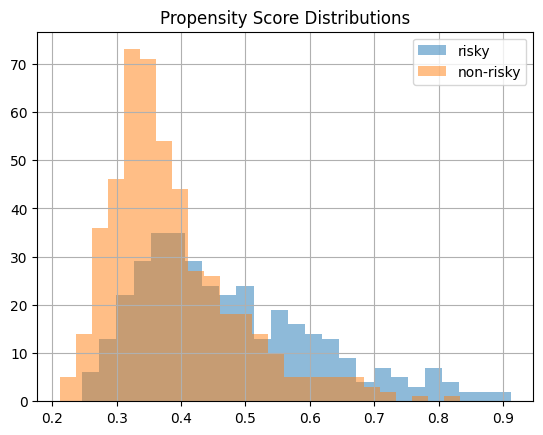

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#coastal_risk = risk_variables[['zip','landAreaTotal','waterAreaTotal']].drop_duplicates()
#coastal_risk['water_ratio'] = coastal_risk['waterAreaTotal']/(coastal_risk['waterAreaTotal']+coastal_risk['landAreaTotal'])
#coastal_risk['risk_group'] = coastal_risk['water_ratio'] > coastal_risk['water_ratio'].mean()

#coastal_risk = coastal_risk.set_index('zip')

risk_variables['waterAreaProp'] = risk_variables['waterAreaTotal'] / (risk_variables['landAreaTotal']+risk_variables['waterAreaTotal'])
zip_ = \
risk_variables.groupby(['zip']).agg(
    numberEvents=pd.NamedAgg(column='floodEvent',aggfunc='count'), 
    totalClaims=pd.NamedAgg(column='totalClaimZip',aggfunc='sum'), 
    totalLosses=pd.NamedAgg(column='totalLossesZip',aggfunc='sum'), 
    waterAreaProp=pd.NamedAgg(column='waterAreaProp',aggfunc='max')
)

zip_['log(totalClaims)'] = np.log(zip_['totalClaims']+0.000001) 
zip_['log(totalLosses)'] = np.log(zip_['totalLosses']+0.000001) 

zip_ = zip_.drop(columns=['totalClaims','totalLosses']) 

rfs = [
    'numberEvents', 
    'waterAreaProp', 
    'log(totalLosses)'
]

st = StandardScaler()
rf_matrix = zip_[rfs].values
rf_matrix_st = StandardScaler().fit_transform(rf_matrix).mean(axis=1)
zip_['risk_score'] = rf_matrix_st
zip_['risk_group'] = rf_matrix_st > rf_matrix_st.mean()

ttl_zip = pd.concat((feature_matrix, zip_[['risk_group']]),axis=1).dropna()

prop_score_lr = LogisticRegression() 

X = ttl_zip.iloc[:,:-1].values
y = ttl_zip['risk_group'].astype(bool)

prop_score_lr.fit(X,y) 
ttl_zip['propensity_score'] = prop_score_lr.predict_proba(X)[:,1]

ttl_zip.loc[ttl_zip['risk_group']]['propensity_score'].hist(alpha=0.5,label='risky',bins=25)
ttl_zip.loc[ttl_zip['risk_group']==False]['propensity_score'].hist(alpha=0.5,label='non-risky',bins=25)
plt.title('Propensity Score Distributions')
plt.legend()
plt.show()

In [96]:
from sklearn.neighbors import NearestNeighbors

COVERED = set()
def search_closest_match(output_idx_lst, df=ttl_zip):
    for i in output_idx_lst[1:]:
        
        r = df.iloc[i]
        zip = r.name
        
        if r['risk_group']:
            if zip in COVERED:
                continue 
            else:
                COVERED.add(zip)
                return zip

def calc_risk_diff(r, df=zip_):
    zips = [
        r['matched_zip_nonrisky'], r['matched_zip_risky']
    ]
    diff_r = df.loc[zips]['risk_score'].diff().abs().iloc[-1]
    return diff_r 
    
dataset_match = ttl_zip.loc[ttl_zip['risk_group']==False][['propensity_score']]
prop_score = ttl_zip['propensity_score'].to_numpy().reshape(-1,1)

nn = NearestNeighbors(n_neighbors=10) 
nn.fit(prop_score)

control = dataset_match['propensity_score'].to_numpy().reshape(-1,1)
_, nearest_i = nn.kneighbors(control)

zip_matched = [
    search_closest_match(i) for i in nearest_i
]
dataset_match['matched_zip_risky'] = zip_matched

dataset_match = \
dataset_match\
    .reset_index()\
    .drop(columns=['propensity_score'])\
    .rename(
        columns={
            'zip':'matched_zip_nonrisky'
        }
)

dataset_match = dataset_match.dropna()
dataset_match['risk_diff'] = dataset_match.apply(calc_risk_diff,axis=1)
dataset_match

,matched_zip_nonrisky,matched_zip_risky,risk_diff
0,32008,33157,0.380417
1,32009,32092,0.950660
2,32011,33351,0.329922
3,32024,34946,0.519530
4,32025,33024,0.815474
...,...,...,...
473,34788,33982,0.399210
474,34797,32139,1.069627
482,34974,32955,0.263719
483,34981,33523,0.566405


In [98]:
ts=homeprices.set_index('zip').drop(columns=['Metro','CountyName']).T
ts_roc = ts.diff().div(ts)
d=ts_roc.rolling(4).mean()

def weight_func(df, alpha):
    df=df.dropna()
    N=len(df)
    w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
    w_norm = w/w.sum() 
    v = 1e3*(df.T@w_norm)
    idx = v-v.mean()
    return idx
    
idx=weight_func(d, 0.0000005)
def search_index(zip, s=idx):
    return s.loc[zip]
    
dataset_match['deviation_weight'] = dataset_match['risk_diff']/dataset_match['risk_diff'].mean()
dataset_match = dataset_match.drop(columns=['risk_diff'])
dataset_match['idx_nonrisky'] = dataset_match['matched_zip_nonrisky'].apply(search_index)
dataset_match['idx_risky'] = dataset_match['matched_zip_risky'].apply(search_index)
dataset_match['idx_diff'] = dataset_match['idx_risky']-dataset_match['idx_nonrisky']
dataset_match


,matched_zip_nonrisky,matched_zip_risky,deviation_weight,idx_nonrisky,idx_risky,idx_diff
0,32008,33157,0.379146,6.020553,6.996302,0.975749
1,32009,32092,0.947484,3.119856,-1.276938,-4.396794
2,32011,33351,0.328820,4.338910,0.233858,-4.105052
3,32024,34946,0.517794,4.028560,-2.452171,-6.480731
4,32025,33024,0.812750,2.374855,2.541111,0.166257
...,...,...,...,...,...,...
473,34788,33982,0.397876,-0.459488,-5.472285,-5.012797
474,34797,32139,1.066054,2.087353,3.653414,1.566061
482,34974,32955,0.262839,3.579531,-0.756459,-4.335990
483,34981,33523,0.564513,-0.239079,0.044275,0.283354


use a mathematical optimization approach to find pairings?

In [101]:
dataset_match['idx_diff'].mean()

np.float64(-1.3128376456211546)

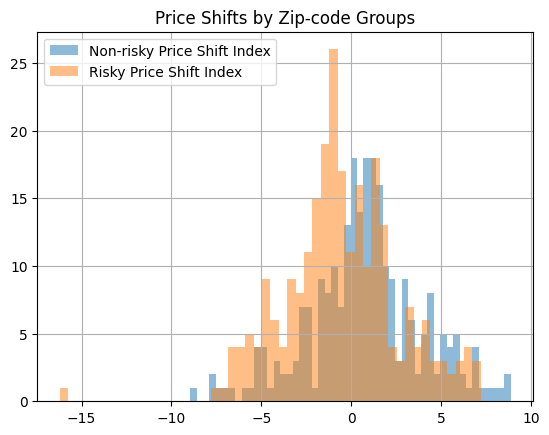

In [103]:
dataset_match['idx_nonrisky'].hist(bins=50, alpha=0.5, label='Non-risky Price Shift Index')
dataset_match['idx_risky'].hist(bins=50, alpha=0.5, label='Risky Price Shift Index')
plt.title('Price Shifts by Zip-code Groups')
plt.legend()
plt.show()

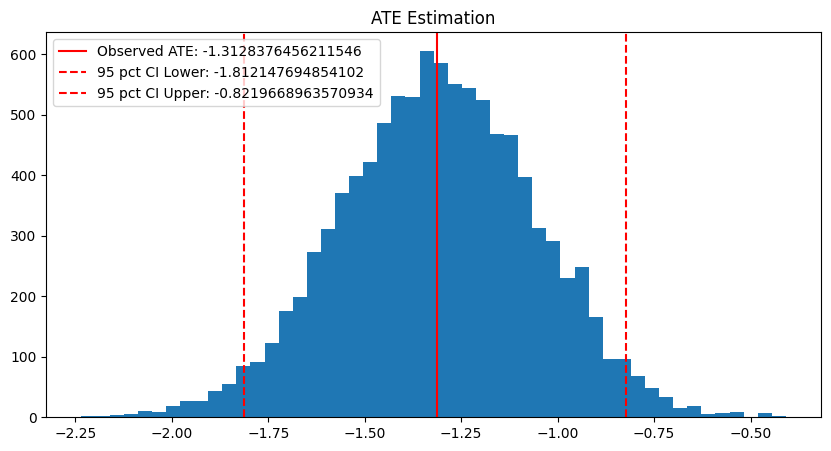

In [104]:
import random 
plt.rcParams['figure.figsize']=(10,5)
diffs = dataset_match['idx_diff']
bootstrapped_sample_dist = pd.Series([diffs.sample(n=len(diffs), replace=True).mean() for _ in np.arange(10000)])
plt.hist(bootstrapped_sample_dist, bins=50,)
plt.title('ATE Estimation')

obs = dataset_match['idx_diff'].mean()
CI = [
    bootstrapped_sample_dist.quantile(0.025), 
    bootstrapped_sample_dist.quantile(0.975)
]
plt.axvline(dataset_match['idx_diff'].mean(), label=f"Observed ATE: {dataset_match['idx_diff'].mean()}",color='red')
plt.axvline(CI[0], label=f"95 pct CI Lower: {CI[0]}",color='red',linestyle='--')
plt.axvline(CI[1], label=f"95 pct CI Upper: {CI[1]}",color='red',linestyle='--')
plt.legend()
plt.show()

In [107]:
dataset_match['deviation_weight'] = dataset_match['risk_diff']/dataset_match['risk_diff'].mean()
np.mean(dataset_match['deviation_weight']*dataset_match['idx_diff'])

KeyError: 'risk_diff'

In [ ]:
dataset_match['deviation_weight'].hist()

#### Forecasting

Compare home prices in local markets to macroeconomic conditions (mortgage rates, consumer confidence, etc.) and broader monetary policy (fed. interest rates, etc.). 

Look at loan-to-value ratio?

See Garriga et. al. https://cpb-us-w2.wpmucdn.com/sites.wustl.edu/dist/6/789/files/2018/01/GMP_01_20_2018_RM-11zc3w0.pdf

In [112]:
import warnings
warnings.filterwarnings('ignore')

risk_variables['year'] = risk_variables['dateOfLoss'].dt.year
risk_variables['month'] = risk_variables['dateOfLoss'].dt.month

flood_loss_monthly = risk_variables\
                        .groupby(['year','month'])\
                        .agg(
                            numberEvents=pd.NamedAgg(column='floodEvent',aggfunc='nunique'), 
                            claimCounts=pd.NamedAgg(column='claimCounts',aggfunc='sum'), 
                            totalLossesZip=pd.NamedAgg(column='totalLossesZip',aggfunc='sum')
                        )\
                        .reset_index()
flood_loss_monthly['date'] = flood_loss_monthly['year'].astype(str) + '-' + flood_loss_monthly['month'].astype(str) 
flood_loss_monthly['date'] = pd.to_datetime(flood_loss_monthly['date'])   
flood_loss_monthly = flood_loss_monthly.set_index('date').drop(columns=['year','month'])
flood_loss_monthly['totalLossesZip'] += 0.00001

flood_loss_monthly['claimCounts'] = np.log(flood_loss_monthly['claimCounts']) 
flood_loss_monthly['totalLossesZip'] = np.log(flood_loss_monthly['totalLossesZip']) 

macro_post2000 = macroeconomic_indicators.loc[macroeconomic_indicators['year']>=2000].drop(columns=['year','month'])
macro_post2000_diff = macro_post2000.diff().div(macro_post2000).dropna()

macro_post2000_diff.corr()

macro_post2000_diff = macro_post2000_diff.drop(columns=['real_disp_income_per_capita','15yr_mortgage_avg'])
macro_post2000_diff_w_risk_factors = pd.concat((macro_post2000_diff,flood_loss_monthly),axis=1)#.dropna()

macro_post2000_diff_w_risk_factors


,fed_funding_rate,30yr_mortgage_avg,consumer_price_idx,real_disposable_income,numberEvents,claimCounts,totalLossesZip
date,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,0,3.583519,10.367064
2000-02-01,0.049948,0.013814,0.004118,0.003863,0,3.258097,9.154299
2000-03-01,0.020282,-0.010316,0.005848,0.002646,0,4.262680,12.574244
2000-04-01,0.027596,-0.010733,-0.000585,0.005013,0,4.043051,12.103104
2000-05-01,0.039629,0.042572,0.001752,0.004099,0,3.583519,11.333117
...,...,...,...,...,...,...,...
2024-09-01,-0.038986,-0.051780,0.002287,0.001427,2,10.890088,21.704510
2024-10-01,-0.062112,0.038581,0.002259,0.003702,1,9.953943,19.840337
2024-11-01,-0.041322,0.055400,0.002797,0.001935,1,3.761200,11.494935


In [114]:
macro_post2000

,fed_funding_rate,30yr_mortgage_avg,15yr_mortgage_avg,consumer_price_idx,real_disposable_income,real_disp_income_per_capita
date,,,,,,
2000-01-01,5.448387,8.2100,7.8025,169.300,9799.9,34865.0
2000-02-01,5.734828,8.3250,7.9325,170.000,9837.9,34973.0
2000-03-01,5.853548,8.2400,7.8320,171.000,9864.0,35037.0
2000-04-01,6.019667,8.1525,7.8000,170.900,9913.7,35184.0
2000-05-01,6.268065,8.5150,8.1825,171.200,9954.5,35300.0
...,...,...,...,...,...,...
2024-11-01,4.638333,6.8050,6.0275,316.449,17618.8,51642.0
2024-12-01,4.475161,6.7150,5.9300,317.603,17646.1,51700.0
2025-01-01,4.330000,6.9580,6.1640,319.086,17744.1,51966.0


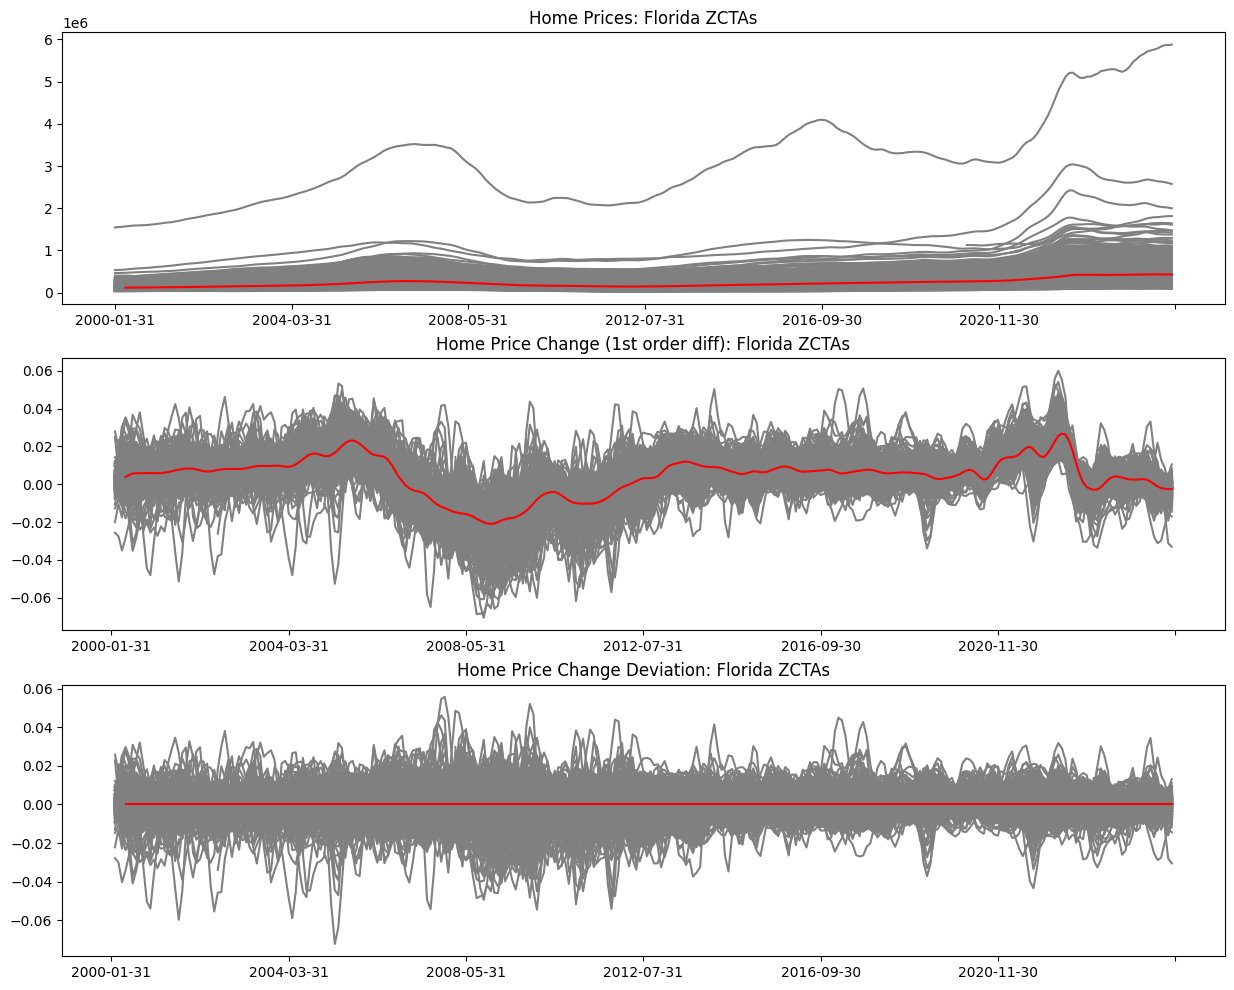

In [162]:
import matplotlib.pyplot as plt 

ts=homeprices.set_index('zip').drop(columns=['Metro','CountyName']).T
ts_rolled = ts.mean(axis=1).rolling(4).mean()
ts_roc = ts.diff().div(ts)
ts_roc_global = ts_roc.mean(axis=1)
ts_roc_global_rolled = ts_roc_global.rolling(4).mean()
ts_roc_resid = ts_roc.sub(ts_roc_global,axis=0)
ts_roc_resid_rolled = ts_roc_resid.mean(axis=1).rolling(4).mean() 
fig,ax=plt.subplots(3,1, figsize=(15,12))
ts.plot(
    legend=False, 
    title='Home Prices: Florida ZCTAs', 
    color='grey',
    ax=ax[0]    
)
ax[0].plot(
    ts_rolled, 
    color='red'
)
ts_roc.plot(
    legend=False, 
    title='Home Price Change (1st order diff): Florida ZCTAs', 
    color='grey',
    ax=ax[1]    
)
ax[1].plot(
    ts_roc_global_rolled, 
    color='red'
)
ts_roc_resid.plot(
    legend=False, 
    title='Home Price Change Deviation: Florida ZCTAs', 
    color='grey',
    ax=ax[2]    
)
ax[2].plot(
    ts_roc_resid_rolled, 
    color='red'
)
#macro_post2000_diff_w_risk_factors[['30yr_mortgage_avg']].plot(
 #   legend=False, 
  #  title='30 Yr Mortgage Avg (1st order diff)', 
   # ax=ax[1]
#)
#macro_post2000_diff_w_risk_factors[['consumer_price_idx']].plot(b
 #   legend=False, 
  #  title='CPI (1st order diff)', 
   # ax=ax[2]
#)
plt.show()

#### inflation adjusted home prices

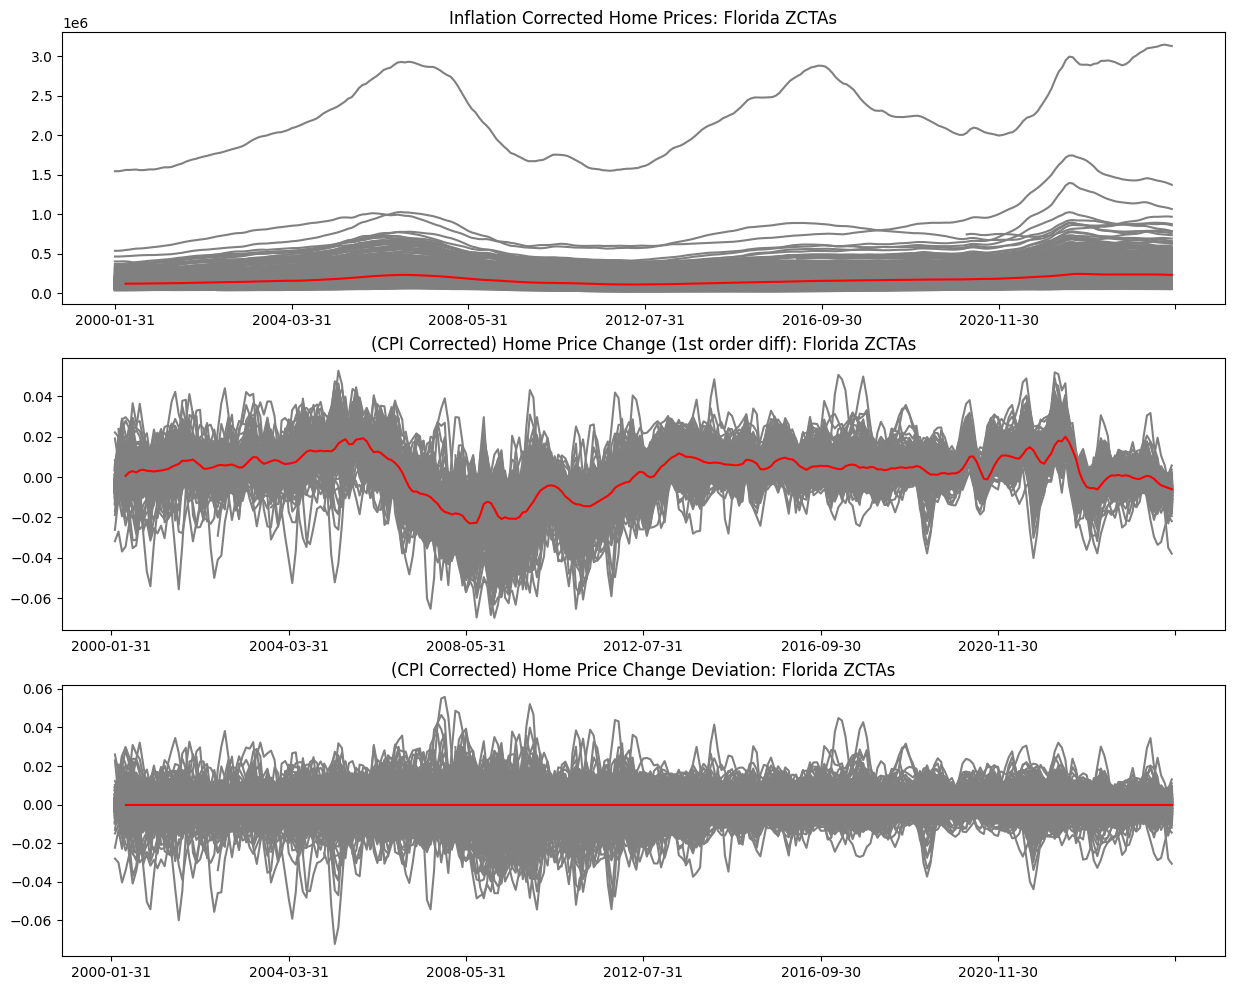

In [165]:
cpi = macro_post2000[['consumer_price_idx']].dropna().iloc[1:-1,:]
cpi['inflation_correction'] = cpi['consumer_price_idx'].iloc[0] / cpi['consumer_price_idx'] 
ts = ts.mul(cpi['inflation_correction'].to_numpy(),axis=0)

ts_rolled = ts.mean(axis=1).rolling(4).mean()
ts_roc = ts.diff().div(ts)
ts_roc_global = ts_roc.mean(axis=1)
ts_roc_global_rolled = ts_roc_global.rolling(4).mean()
ts_roc_resid = ts_roc.sub(ts_roc_global,axis=0)
ts_roc_resid_rolled = ts_roc_resid.mean(axis=1).rolling(4).mean() 
fig,ax=plt.subplots(3,1, figsize=(15,12))
ts.plot(
    legend=False, 
    title='Inflation Corrected Home Prices: Florida ZCTAs', 
    color='grey',
    ax=ax[0]    
)
ax[0].plot(
    ts_rolled, 
    color='red'
)
ts_roc.plot(
    legend=False, 
    title='(CPI Corrected) Home Price Change (1st order diff): Florida ZCTAs', 
    color='grey',
    ax=ax[1]    
)
ax[1].plot(
    ts_roc_global_rolled, 
    color='red'
)
ts_roc_resid.plot(
    legend=False, 
    title='(CPI Corrected) Home Price Change Deviation: Florida ZCTAs', 
    color='grey',
    ax=ax[2]    
)
ax[2].plot(
    ts_roc_resid_rolled, 
    color='red'
)

plt.show()

In [122]:
ts

zip,34787,34953,33024,33411,33025,33311,33023,33012,33015,33186,...,34661,33854,32355,33840,33848,33051,34681,34138,33855,32664
2000-01-31,174839.543016,95888.450982,90455.666751,114329.021532,86437.968796,60314.847112,77011.568108,92074.032540,99705.213375,130145.225705,...,NaN,NaN,NaN,NaN,34608.830704,NaN,179456.302604,NaN,73546.604733,NaN
2000-02-29,175835.303588,96070.556740,90730.381364,114638.534962,86595.214589,60505.254348,77085.305964,92379.590440,100087.893949,130604.822051,...,NaN,NaN,NaN,NaN,34623.690468,NaN,179459.459878,NaN,73420.209041,NaN
2000-03-31,176653.296933,96047.339800,91051.570096,114999.698383,86811.932206,60693.982425,77276.077104,92677.375545,100386.090635,130923.044957,...,NaN,NaN,NaN,NaN,35114.554233,NaN,179569.743900,NaN,73419.275407,NaN
2000-04-30,178102.118495,96101.517231,91729.417877,115649.974913,87277.511666,61096.957517,77715.314751,93246.814037,100988.125133,131578.598941,...,NaN,NaN,NaN,NaN,35758.571239,NaN,180193.505190,NaN,73837.513475,NaN
2000-05-31,179096.578899,96167.953509,92387.934048,116335.361416,87762.208212,61526.539253,78196.617242,93749.469505,101468.650688,132096.481165,...,NaN,NaN,NaN,NaN,36304.568214,NaN,181862.790832,NaN,74086.438617,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,579281.058637,408226.411040,474828.147222,484620.807803,410528.343986,365577.523911,457323.808461,391373.425366,430011.930343,544411.533510,...,149791.010599,92535.159784,258974.062071,189023.622095,201218.105843,919381.230372,721169.635373,184669.819313,293798.608125,293902.057598
2024-09-30,578708.217412,408308.329783,475412.779353,484496.591220,410009.095095,365492.479920,458154.317105,392346.965561,430555.767079,545902.938901,...,149468.319342,91547.755756,258978.402781,187778.641155,200220.196888,916524.232982,720791.200238,182425.246174,294170.258125,294129.087343
2024-10-31,577608.489371,407872.763464,475669.614096,483898.939885,409530.909871,365450.589526,458197.065490,392585.473438,429663.628494,546225.231049,...,150158.102263,91181.844108,258385.074001,186833.588437,200124.017403,912540.027112,719136.688617,181374.507238,294154.534067,294315.393981
2024-11-30,576497.244763,406980.833581,475832.826768,483126.073332,408645.251418,365207.663694,458160.808208,392473.516915,428166.475461,545710.519343,...,150147.896811,91237.083145,257662.412665,185564.431503,201093.717661,908840.243322,714798.044315,179860.284876,293979.874289,293799.191313


<Axes: >

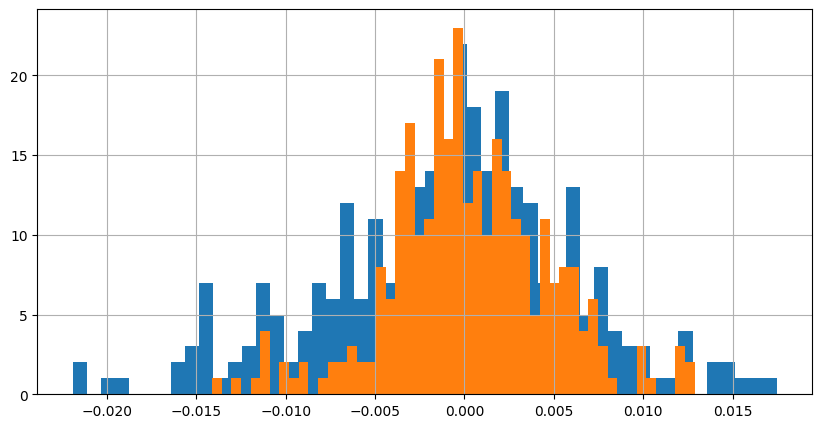

In [1237]:
furthest=dataset_match.sort_values(by=['deviation_weight']).iloc[-1]

ts_roc_resid[furthest['matched_zip_nonrisky']].hist(bins=50)
ts_roc_resid[furthest['matched_zip_risky']].hist(bins=50)

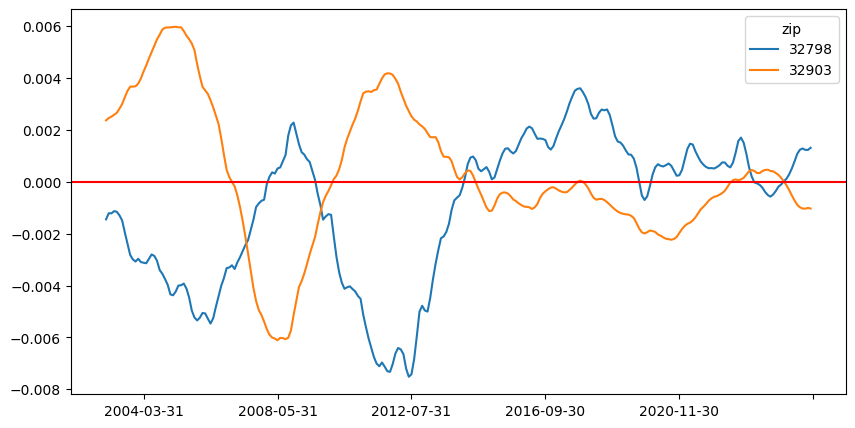

In [1279]:
ts_roc_resid[[furthest['matched_zip_nonrisky'],furthest['matched_zip_risky']]].rolling(36).mean().plot()
plt.axhline(0,color='red')
plt.show()

In [1281]:
furthest


matched_zip_nonrisky       32798
matched_zip_risky          32903
idx_nonrisky            1.656226
idx_risky              -2.939232
idx_diff               -4.595458
deviation_weight        3.938256
Name: 149, dtype: object

In [897]:
df_ttl = macro_post2000_diff_w_risk_factors.iloc[1:,:]
df_ttl['home_price_change'] = ts_roc_global.to_numpy()
df = df_ttl.fillna(method='bfill')

df.corr()

,fed_funding_rate,30yr_mortgage_avg,consumer_price_idx,real_disposable_income,numberEvents,claimCounts,totalLossesZip,home_price_change
fed_funding_rate,1.000000,0.107930,0.298831,-0.343478,0.041051,0.056099,0.050591,0.072749
30yr_mortgage_avg,0.107930,1.000000,0.298371,0.036961,-0.035895,-0.006604,0.025449,0.204365
consumer_price_idx,0.298831,0.298371,1.000000,-0.157287,0.131066,0.032147,0.022927,0.176677
real_disposable_income,-0.343478,0.036961,-0.157287,1.000000,-0.010477,-0.051367,-0.028630,-0.006230
numberEvents,0.041051,-0.035895,0.131066,-0.010477,1.000000,0.690226,0.385787,0.089759
claimCounts,0.056099,-0.006604,0.032147,-0.051367,0.690226,1.000000,0.659951,0.075346
totalLossesZip,0.050591,0.025449,0.022927,-0.028630,0.385787,0.659951,1.000000,0.153785
home_price_change,0.072749,0.204365,0.176677,-0.006230,0.089759,0.075346,0.153785,1.000000


In [899]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

st = StandardScaler().fit_transform(df) 
X = sm.add_constant(st[:,:-1])
y = st[:,-1]
m = sm.OLS(y,X) 
res=m.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.766
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           0.000630
Time:                        22:11:03   Log-Likelihood:                -412.72
No. Observations:                 300   AIC:                             841.4
Df Residuals:                     292   BIC:                             871.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.939e-17      0.056  -1.24e-15      1.000      -0.110       0.110
x1             0.0189      0.062      0.305      0.761      -0.103       0.141
x2             0.1661      0.059      2.798      0.005       0.049       0.283
x3             0.1118      0.062      1.789      0.075      -0.011       0.235
x4             0.0124      0.060      0.206      0.837      -0.106       0.131
x5             0.0828      0.080      1.040      0.299      -0.074       0.239
x6            -0.1067      0.097     -1.106      0.270      -0.297       0.083
x7             0.1849      0.075      2.456      0.015       0.037       0.333
==============================================================================
Omnibus:                       25.797   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.862
Skew:                          -0.750   Prob(JB):                     3.28e-07
Kurtosis:                       3.375   Cond. No.                         3.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""